In [30]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import numpy as np
import torch.nn as nn
import torch
from tqdm import tqdm
import datetime
import time
import random
import os
import sys
import json

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset

In [31]:
ROOT_DIR = "/mnt/ssd/ronak/datasets/wilds"
CACHE_DIR = "/mnt/ssd/ronak/models"
SAVE_DIR = "/mnt/hdd/ronak/wilds/amazon"
OUT_DIR = "/mnt/ssd/ronak/output/wilds/amazon"

## Build Dataset

Determine the padding length based on the average length of encoded sentences. We then tokenize the dataset and save it to disk.

In [16]:
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="amazon", download=True, root_dir=ROOT_DIR)

In [17]:
tokenizer = AutoTokenizer.from_pretrained("timinar/baby-llama-58m", cache_dir=CACHE_DIR)

In [27]:
def get_lens(split, n, tokenizer):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    lens = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    # if split != "train":
    #     idx = np.arange(len(sentences))
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        encoded_dict = tokenizer(
            x[0], 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            return_tensors="pt", 
        )

        # Add the encoded sentence to the list.
        lens.append(encoded_dict["input_ids"].shape[1])

        if i == n - 1:
            break

    return np.array(lens)


# generate encoded tokens:
def get_split(split, n, tokenizer, max_length=80):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    metadata = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    # if split != "train":
    #     idx = np.arange(len(sentences))
    print(f"Loader size: {len(loader)}.")
    for i, (x, y, z) in tqdm(enumerate(loader)):
        # first encode fully and check length
        encoded_dict = tokenizer(
            x[0], 
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            return_tensors="pt", 
        )

        # then continue if length is small
        if encoded_dict["input_ids"].shape[1] <= max_length:
            encoded_dict = tokenizer(
                x[0], 
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors="pt",  # Return pytorch tensors.return_tensors='pt'
                return_attention_mask=True,
            )

            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict["input_ids"])
            attn_masks.append(encoded_dict["attention_mask"])
            labels.append(y.item())
            metadata.append(z)

        if len(input_ids) == n - 1:
            break

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    metadata = torch.cat(metadata)

    return input_ids, attn_masks, labels, metadata

In [21]:
n = 10000
seq_len = get_lens("train", n, tokenizer)

Loader size: 245502.


0it [00:00, ?it/s]

9999it [00:06, 1604.82it/s]

4959


0.5 quantile: 129.0
0.75 quantile: 254.0
0.9 quantile: 393.0


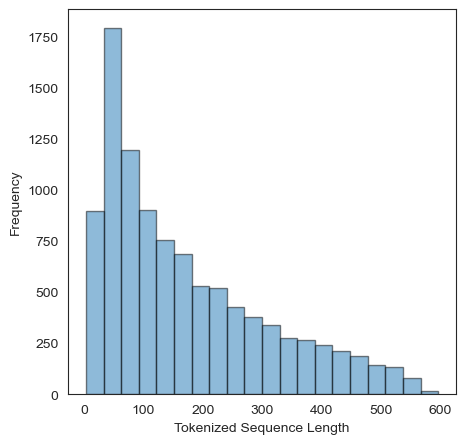

In [28]:
for q in [0.5, 0.75, 0.9]:
    print(f"{q} quantile: {np.quantile(seq_len, q)}")

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(seq_len, bins=20, color="tab:blue", alpha=0.5, edgecolor="k")
ax.set_xlabel("Tokenized Sequence Length")
ax.set_ylabel("Frequency")
plt.show()

We choose `80` as the sequence length and keep only those examples that are short.

In [29]:
n = np.inf
for split in ["train", "val", "test"]:
    input_ids, attn_masks, labels, metadata = get_split(split, n, tokenizer, max_length=80)
    
    print(input_ids.shape)
    torch.save(input_ids, os.path.join(SAVE_DIR, f"{split}_input_ids.pt"))
    torch.save(attn_masks, os.path.join(SAVE_DIR, f"{split}_attn_masks.pt"))
    torch.save(labels, os.path.join(SAVE_DIR, f"{split}_labels.pt"))
    torch.save(metadata, os.path.join(SAVE_DIR, f"{split}_metadata.pt"))

Loader size: 245502.


0it [00:00, ?it/s]

245502it [03:31, 1160.72it/s]


torch.Size([85586, 80])
Loader size: 100050.


100050it [01:20, 1235.87it/s]


torch.Size([38669, 80])
Loader size: 100050.


100050it [01:21, 1227.95it/s]


torch.Size([39128, 80])


## Train Model

We begin the training procedure.

In [32]:
LEARNING_RATE = 2e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 4
EPOCHS = 2
SEED = 123
UNFROZEN = 1
device = "cuda:0"

In [33]:
## model

n_labels = 5
model = AutoModelForSequenceClassification.from_pretrained("timinar/baby-llama-58m", cache_dir=CACHE_DIR)

# model surgery
model.score = nn.Linear(in_features=512, out_features=n_labels, bias=False)
model.num_labels = n_labels


for param in model.parameters():
    param.requires_grad = False
for module in model.model.layers[-UNFROZEN:] + [model.model.norm, model.score]:
    for param in module.parameters():
        param.requires_grad = True

model.to(device)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at timinar/baby-llama-58m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(16000, 512, padding_idx=0)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=512, out_features=1024, bias=False)
          (up_proj): Linear(in_features=512, out_features=1024, bias=False)
          (down_proj): Linear(in_features=1024, out_features=512, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNor

In [34]:
class Amazon(Dataset):
    def __init__(self, input_ids, attn_masks, labels, metadata):
        self.input_ids = input_ids
        self.attn_masks = attn_masks
        self.labels = labels
        self.metadata = metadata

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i], self.metadata[i]
    
def load_dataset(split):
    input_ids = torch.load(os.path.join(SAVE_DIR, f"{split}_input_ids.pt"))
    attn_masks = torch.load(os.path.join(SAVE_DIR, f"{split}_attn_masks.pt"))
    labels = torch.load(os.path.join(SAVE_DIR, f"{split}_labels.pt"))
    metadata = torch.load(os.path.join(SAVE_DIR, f"{split}_metadata.pt"))

    return Amazon(input_ids, attn_masks, labels, metadata)

In [35]:
# small enough to fit in CPU memory
train_dataset = load_dataset("train")
val_dataset = load_dataset("val")

a = train_dataset.input_ids
print(f"Train dataset size: {a.element_size() * a.numel() / (1024 ** 3):0.2f}G")

train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(train_dataset)))
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

Train dataset size: 0.05G
85,586 training samples.
38,669 validation samples.


In [38]:
print(np.bincount(train_dataset.labels.numpy()) / len(train_dataset))
print(np.bincount(val_dataset.labels.numpy()) / len(val_dataset))

[0.01191784 0.02264389 0.08014161 0.26771902 0.61757764]
[0.01399054 0.02280897 0.07626264 0.24254571 0.64439215]


In [50]:
np.unique(train_dataset.metadata[:, 2].numpy())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

In [10]:
def to_dict_of_lists(lst):
    return {key: [i[key] for i in lst] for key in lst[0]}

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 200 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_dataloader), elapsed
                )
            )

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        output = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = output.loss
        logits = output.logits
        

        total_train_loss += loss.item()

        loss.backward()

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model, os.path.join(OUT_DIR, "erm.pt"))
training_stats = to_dict_of_lists(training_stats)
with open(os.path.join(OUT_DIR, "erm.json"), "w") as f:
    json.dump(training_stats, f, indent=2)

## Understanding Performance

We now look at the performance numbers.